In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import itertools
import random
import cv2
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from tensorflow.keras.utils import img_to_array, load_img
from scipy.spatial import distance
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

In [2]:
mask_path="C:\data\WithMask"
no_mask_path = "C:\data\WithoutMask"

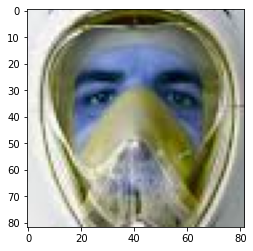

In [3]:
for img in os.listdir(mask_path):
    img_array= cv2.imread(os.path.join(mask_path,img))
    plt.imshow(img_array)
    plt.show()
    break

IMG_SIZE = 82;
new_array =cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))

training_data=[]

In [4]:
# Labeling and resizing the data
def create_training_data():
    class_num_1 = 0
    class_num_2 = 1
    
    for img in os.listdir(mask_path):
        try:
            img_array= cv2.imread(os.path.join(mask_path,img)) 
            new_array =cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
            training_data.append([new_array,class_num_1])
        except Exception as e:
            pass

    for img in os.listdir(no_mask_path):
        try:
            img_array= cv2.imread(os.path.join(no_mask_path,img)) 
            new_array =cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
            training_data.append([new_array,class_num_2])
        except Exception as e:
            pass
       
create_training_data()

In [5]:
random.shuffle(training_data)
X=[]
y=[]

for features, label in training_data:
    X.append(features)
    y.append(label)
    

X = np.array(X).reshape(-1,IMG_SIZE,IMG_SIZE,3) # BGR
y = np.array(y)        

In [6]:
import tensorflow as tf
from keras.applications.resnet import ResNet101
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation,Flatten


# Train-Test Split

x_train,x_test,y_train, y_test = train_test_split(X,y,test_size = 0.2,random_state=2)

x_train=x_train/255.0
x_test= x_test/255.0


In [7]:
# IF we run this cell, we do transfer learning on ResNet101. It does not increase our accuracy significantly
# because it is a easy task and simple dataset. But, this structure works fine and can be used for more complex tasks

resnet = ResNet101(include_top = False,weights="imagenet",input_shape=(IMG_SIZE,IMG_SIZE,3))
print(resnet.summary())
resnet.trainable= False

layer_list = resnet.layers
model = Sequential()
model.add(resnet)
model.add(Flatten())
model.add(Dense(1024,activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(1024,activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(1,activation="sigmoid"))
print(model.summary())

optimizer = Adam(learning_rate=0.001)
model.compile(loss = "binary_crossentropy",
             optimizer=optimizer,
              metrics=["accuracy"])
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # dimesion reduction
        rotation_range=5,  # randomly rotate images in the range 5 degrees
        zoom_range = 0.01, # Randomly zoom image 10%
        width_shift_range=0.1,  # randomly shift images horizontally 10%
        height_shift_range=0.1,  # randomly shift images vertically 10%
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images
batch_size = 128;
epochs=90;
datagen.fit(x_train)
history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs,  steps_per_epoch=x_train.shape[0] // batch_size)

In [13]:
#Basic Sequentail CNN model, it works efficiently for detecting feature maps of images because it is a binary classification


model = Sequential()
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu', input_shape = x_train.shape[1:]))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256,activation="relu"))


model.add(Dense(256,activation="relu"))


model.add(Dense(1))
model.add(Activation("sigmoid"))
model.compile(loss="binary_crossentropy",
              optimizer=Adam(lr=0.001),
              metrics=['accuracy'])    
epochs = 5
batch_size = 32

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # dimesion reduction
        rotation_range=5,  # randomly rotate images in the range 5 degrees
        zoom_range = 0.01, # Randomly zoom image 10%
        width_shift_range=0.1,  # randomly shift images horizontally 10%
        height_shift_range=0.1,  # randomly shift images vertically 10%
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images

datagen.fit(x_train)
#history = model.fit(x_train,y_train, batch_size=32,epochs=5,validation_split=0.1)
history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_test,y_test), steps_per_epoch=x_train.shape[0] // batch_size)

C:\Users\umut_\anaconda4\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/5


C:\Users\umut_\AppData\Local\Temp\ipykernel_24120\1043377483.py:43: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),


270/270 [==============================] - 53s 194ms/step - loss: 0.3226 - accuracy: 0.8660 - val_loss: 0.1876 - val_accuracy: 0.9218
Epoch 2/5
270/270 [==============================] - 56s 206ms/step - loss: 0.1936 - accuracy: 0.9244 - val_loss: 0.1491 - val_accuracy: 0.9426
Epoch 3/5
270/270 [==============================] - 51s 189ms/step - loss: 0.1597 - accuracy: 0.9395 - val_loss: 0.1275 - val_accuracy: 0.9505
Epoch 4/5
270/270 [==============================] - 52s 192ms/step - loss: 0.1516 - accuracy: 0.9443 - val_loss: 0.0998 - val_accuracy: 0.9630
Epoch 5/5
270/270 [==============================] - 54s 199ms/step - loss: 0.1364 - accuracy: 0.9522 - val_loss: 0.1142 - val_accuracy: 0.9574


In [7]:
from keras.models import load_model
model = load_model("cnn_model")

In [8]:
plt.plot(history.history["loss"],label = "Train loss")
plt.plot(history.history["val_loss"],label="Val loss")
plt.legend()
plt.show()

NameError: name 'history' is not defined

In [ ]:
y_pred=model.predict(x_test)
y_pred
y_pred.shape
for i in range(len(y_pred)):
    if y_pred[i]<0.5:
        y_pred[i]=0
    else:
        y_pred[i]=1

In [ ]:
confusion_matrix(y_test,y_pred)

In [ ]:
maskeli = cv2.imread("maskeli.jpg")
maskeli = cv2.resize(maskeli,(82,82))
maskeli = np.array(maskeli).reshape(1,82,82,3)
maskeli = maskeli/255.0

#plt.imshow(maskeli)

a= model.predict(maskeli)
a
# maskesiz 1

In [39]:
#We are cropping faces from the image and save it as "face.jpg". To not confuse our model and to get better results,
#we need only the faces of images as cropped format
img = cv2.imread('a.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  
# Load the cascade
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
  
# Detect faces
faces = face_cascade.detectMultiScale(gray, 1.1, 4)
  
# Draw rectangle around the faces and crop the faces
for (x, y, w, h) in faces:
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 0, 255), 2)
    faces = img[y:y + h, x:x + w]
    cv2.imwrite('face.jpg', faces)
      
# Display the output


In [40]:
cv2.waitKey()
# We do predicts by using "face.jpg"
maskeli = cv2.imread("face.jpg")
maskeli = cv2.resize(maskeli,(82,82))
maskeli = np.array(maskeli).reshape(1,82,82,3)
maskeli = maskeli/255.0

#plt.imshow(maskeli)

a= model.predict(maskeli)
if(a<0.4):
    print("Masked")
else:
    print("Unmasked")
# maskesiz 1

1/1 [==============================] - 0s 16ms/step
Kişi Maskesiz
